In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting 4 decimal
plt.rcParams["figure.figsize"] = [9,5]
plt.style.use('ggplot')

In [ ]:
data_df = pd.read_csv("forestfires.csv")

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


We need to convert Month and Day to either "int" or "float" from 'Object' data type or just drop them really

 Other observation is no missing values are present(all are non-null) so we are good to go ahead.

 If suppose missing values were really present(NaN) we can:

1.   Fill them all with a single value using --> df.fillna(0)
2.   Fill them with the pevious or next values --> df.fillna(method = 'pad') || df.fillna(method = 'bfill')
3. Use the replace function

In [ ]:
df = data_df.drop(['month', 'day'], axis=1)
df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,86.2000,26.2000,94.3000,5.1000,8.2000,51,6.7000,0.0000,0.0000
1,7,4,90.6000,35.4000,669.1000,6.7000,18.0000,33,0.9000,0.0000,0.0000
2,7,4,90.6000,43.7000,686.9000,6.7000,14.6000,33,1.3000,0.0000,0.0000
3,8,6,91.7000,33.3000,77.5000,9.0000,8.3000,97,4.0000,0.2000,0.0000
4,8,6,89.3000,51.3000,102.2000,9.6000,11.4000,99,1.8000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6000,56.7000,665.6000,1.9000,27.8000,32,2.7000,0.0000,6.4400
513,2,4,81.6000,56.7000,665.6000,1.9000,21.9000,71,5.8000,0.0000,54.2900
514,7,4,81.6000,56.7000,665.6000,1.9000,21.2000,70,6.7000,0.0000,11.1600
515,1,4,94.4000,146.0000,614.7000,11.3000,25.6000,42,4.0000,0.0000,0.0000


Number of columns is reduced from 13 to 11 hence Month and Day have been dropped

FFMC --> fine fuel moisture code

DMC --> duff moisture code

DC --> drought code

ISI --> initial spread index

RH --> relative humidity

The FWI is open-source and free to use provided by the Canadian Gov here: https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system

Source-Code of FWI: https://publications.gc.ca/collections/collection_2016/rncan-nrcan/Fo133-1-424-eng.pdf

In [ ]:
print("Skew: \n{}".format(df.skew()))
print("\nKurtosis: \n{}".format(df.kurtosis()))

Skew: 
X       0.0362
Y       0.4173
FFMC   -6.5756
DMC     0.5475
DC     -1.1004
ISI     2.5363
temp   -0.3312
RH      0.8629
wind    0.5710
rain   19.8163
area   12.8469
dtype: float64

Kurtosis: 
X       -1.1723
Y        1.4206
FFMC    67.0660
DMC      0.2048
DC      -0.2452
ISI     21.4580
temp     0.1362
RH       0.4382
wind     0.0543
rain   421.2960
area   194.1407
dtype: float64


 To understand Skewness and Kurtosis this article from "Towards Data Science" is very helpful: https://towardsdatascience.com/skewness-kurtosis-simplified-1338e094fc85

 The **horizontal push or pull** distortion of a normal distribution curve gets captured by the "Skewness"

 And the **vertical push or pull** distortion gets captured by the "Kurtosis" measure.
 Also, it is the impact of outliers that dominate the kurtosis effect which has its roots of proof sitting in the fourth-order moment-based formula.

 We can clearly see that the columns : [FFMC, ISI, rain, area]
 to have many outliers

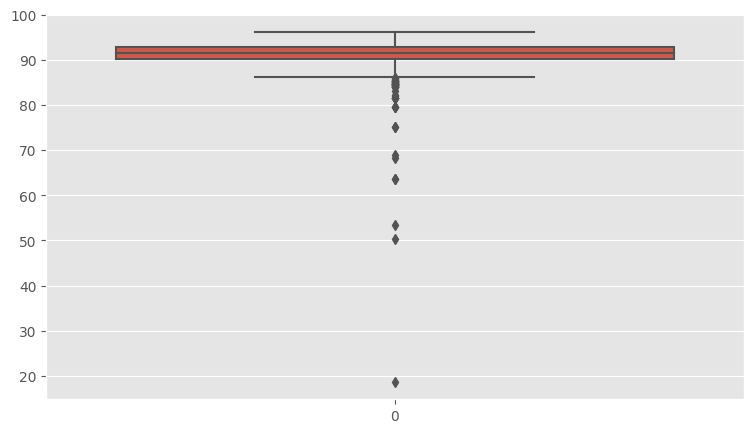

In [ ]:
outl_dect = sns.boxplot(data_df['FFMC'], orient="v")

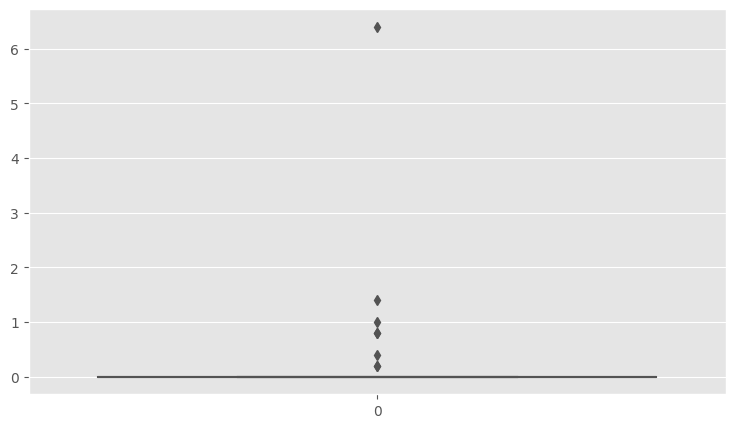

In [ ]:
outl_dect = sns.boxplot(data_df['rain'])

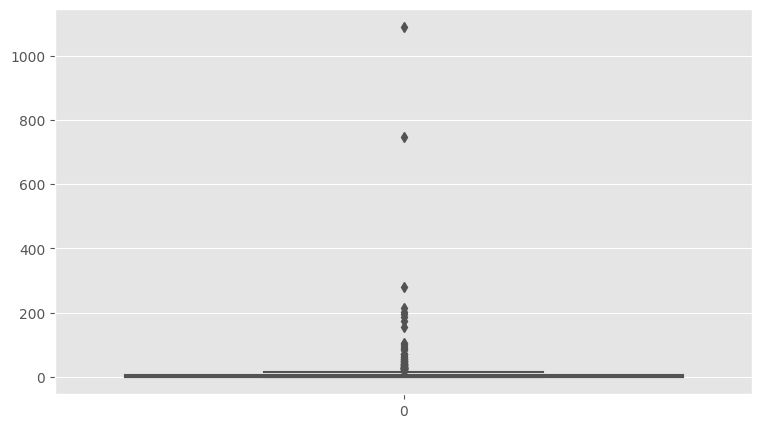

In [ ]:
outl_dect = sns.boxplot(data_df['area'])

Instead of simply removing all the outliers let us first try to normalise the values

In [ ]:
outlier_columns = ['area','FFMC','ISI','rain']
print("Skew after log operation:\n")
np.log1p(data_df[outlier_columns]).skew()
# The logarithmic operation gives output ln(x+1) where x is any element of input array

Skew after log operation:



area     1.2178
FFMC   -11.6754
ISI     -0.9372
rain    14.1730
dtype: float64

In [ ]:
print("Kurtosis after log operation:\n")

np.log1p(data_df[outlier_columns]).kurtosis()

Kurtosis after log operation:



area     0.9457
FFMC   185.4824
ISI      2.5846
rain   234.2400
dtype: float64

Even after log transformations "FFMC" and "rain" have many outliers. So removing them using Zscore method

In [ ]:
data_df.shape

(517, 13)

In [ ]:
mask = data_df.loc[:,['FFMC']].apply(zscore).abs() < 3
data_df = data_df[mask.values]
data_df.shape

(510, 13)

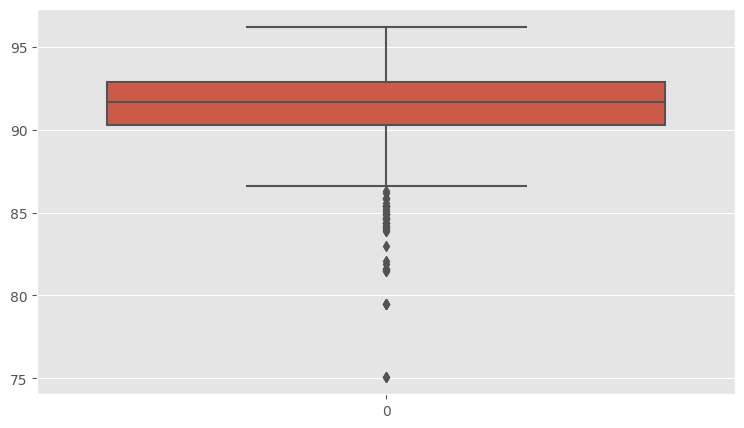

In [ ]:
outl_dect = sns.boxplot(data_df['FFMC'], orient="v")

In [ ]:
data_df['rain'] = data_df['rain'].apply(lambda x: int(x > 0.0))

In [ ]:
outlier_columns.remove('rain')
data_df[outlier_columns] = np.log1p(data_df[outlier_columns])

In [ ]:
data_df[outlier_columns].skew()

area    1.2085
FFMC   -1.8040
ISI    -0.4344
dtype: float64

In [ ]:
data_df[outlier_columns].kurtosis()

area   0.9234
FFMC   4.8667
ISI    1.1226
dtype: float64

In [ ]:
data_df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000,510.0000
mean,4.6804,4.2941,4.5226,111.8376,550.4704,2.2285,18.9516,44.0294,4.0173,0.0157,1.1214
std,2.3205,1.2346,0.0350,63.8537,246.6307,0.4288,5.7899,15.9683,1.7888,0.1244,1.4014
min,1.0000,2.0000,4.3320,3.0000,7.9000,0.7419,2.2000,15.0000,0.4000,0.0000,0.0000
25%,3.0000,4.0000,4.5142,73.2500,442.3000,2.0412,15.6250,32.2500,2.7000,0.0000,0.0000
50%,4.0000,4.0000,4.5288,108.4000,664.2000,2.2407,19.3000,41.5000,4.0000,0.0000,0.4572
75%,7.0000,5.0000,4.5422,142.4000,714.2000,2.4849,22.8000,53.0000,4.9000,0.0000,2.0252
max,9.0000,9.0000,4.5768,291.3000,860.6000,4.0448,33.3000,99.0000,9.4000,1.0000,6.9956


Dataset is now ready for model preparation

In [ ]:
data_sel = data_df.copy() # Copyinh only since the dataset is small

Begin to apply the XGBoost Regressor

In [ ]:
le = LabelEncoder()

data_sel['day']= le.fit_transform(data_sel['day'])
data_sel['month']= le.fit_transform(data_sel['month'])

In [ ]:
X, y = data_sel.iloc[:,:-1],data_sel.iloc[:,-1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

# 33% testing data and the remaining 67% as training

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 17)

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)] # Here we can have a validation set from original dataset but since it is already smalll I decided to proceed ahead with the training and testing set

# verbose set to False so that we can hide results of model fit progress
xg_reg.fit(X_train, y_train, eval_metric=["rmse"], eval_set = eval_set)
preds = xg_reg.predict(X_test)

[0]	validation_0-rmse:1.53108	validation_1-rmse:1.45710
[1]	validation_0-rmse:1.50824	validation_1-rmse:1.44051
[2]	validation_0-rmse:1.49041	validation_1-rmse:1.42560
[3]	validation_0-rmse:1.47559	validation_1-rmse:1.41260
[4]	validation_0-rmse:1.46151	validation_1-rmse:1.40263
[5]	validation_0-rmse:1.45095	validation_1-rmse:1.39430
[6]	validation_0-rmse:1.44153	validation_1-rmse:1.38773
[7]	validation_0-rmse:1.42940	validation_1-rmse:1.38437
[8]	validation_0-rmse:1.41767	validation_1-rmse:1.38333
[9]	validation_0-rmse:1.40645	validation_1-rmse:1.37608
[10]	validation_0-rmse:1.40199	validation_1-rmse:1.37376
[11]	validation_0-rmse:1.39716	validation_1-rmse:1.37247
[12]	validation_0-rmse:1.39403	validation_1-rmse:1.37047
[13]	validation_0-rmse:1.38501	validation_1-rmse:1.37067
[14]	validation_0-rmse:1.38227	validation_1-rmse:1.36969
[15]	validation_0-rmse:1.37777	validation_1-rmse:1.36955
[16]	validation_0-rmse:1.37254	validation_1-rmse:1.36880


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
def calc_ISE(X_train, y_train, model):
    '''returns the in-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_train, y_train), rmse

def calc_OSE(X_test, y_test, model):
    '''returns the out-of-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_test, y_test), rmse

# Calculate In-Sample and Out-of-Sample R^2 and Error

In [ ]:
is_r2, ise = calc_ISE(X_train, y_train,xg_reg )
os_r2, ose = calc_OSE(X_test, y_test, xg_reg)

# show dataset sizes
data_list = (('R^2_in', is_r2), ('R^2_out', os_r2),
             ('ISE', ise), ('OSE', ose))
for item in data_list:
    print('{:10}: {}'.format(item[0], item[1]))

R^2_in    : 0.05634689481074706
R^2_out   : 0.0036000964119839995
ISE       : 1.3725362469682376
OSE       : 1.3688007605658952


Clearly test error(OSE) is near to the training error(ISE). i.e our model is good.

In [ ]:
data_sel['area'].describe()

count   510.0000
mean      1.1214
std       1.4014
min       0.0000
25%       0.0000
50%       0.4572
75%       2.0252
max       6.9956
Name: area, dtype: float64

In [ ]:
print('train/test: ',ose/ise)

train/test:  0.9972784060088805


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse)) # RMSE for linear regression =

RMSE: 1.368801


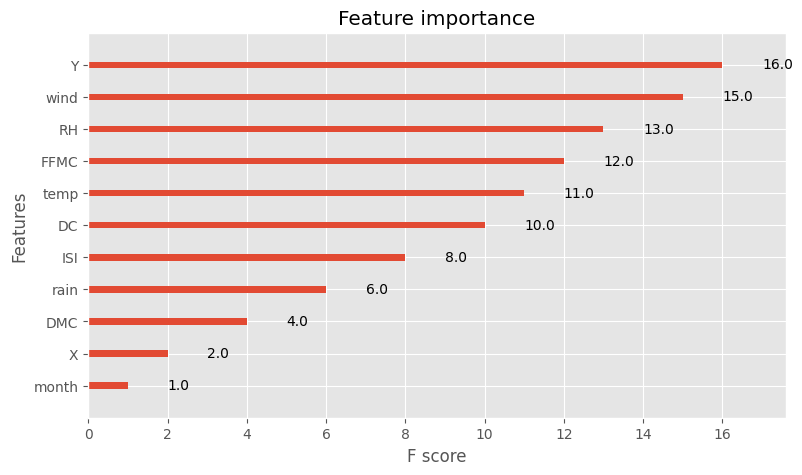

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [7, 7]
plt.show()

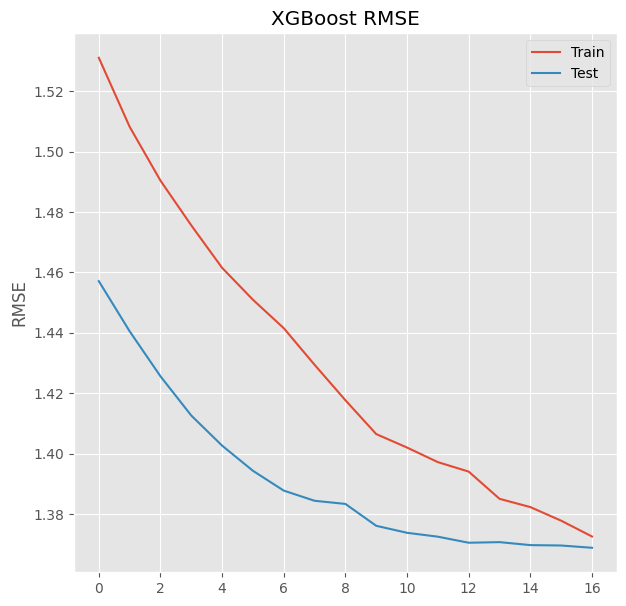

In [ ]:
# retrieve performance metrics
results = xg_reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot Learning Curve
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [ ]:
# Saving model for future prediction on different datasets

xg_reg.save_model('0001_model_forest_fire.json')

# Load the above file on any json viewer to get a glimpse of the tree

# Scope of Improvement

*   Directly use remote sensing techniques instead of the metereological data such as implementing CNN on a satellite image to extract data and features and then train our model. Currently a lot of research is going on in this area and this has tremendous potential in the coming times. Ex: FireNet

*   To save time I did not proceed with hyperparameter optimization but just proceeded with plugging random values. But on a macro scale I think it will have a much larger impact.

*   Use Google Earth Engine to extract all the data hence buidling an end-to-end pipeline without even the need to input the data. Infact I even found a research paper by an Indonesian agency where they have developed a FWI calculator using GEE API for Indonesian Fire Danger Rating System.
Link: https://iopscience.iop.org/article/10.1088/1755-1315/936/1/012040